In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import copy
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as LR

import torchvision
import torchvision.transforms as transforms

In [2]:
class NN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(NN, self).__init__()

    def forward(self, x):
        return x
    
    def update(self, u, v, eta=None):
        pass
    
class BN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(BN, self).__init__()
        self.gain = nn.Parameter(torch.ones(layersize))
        self.bias = nn.Parameter(torch.zeros(layersize))
        
    def forward(self, x):
        
        beta = x.mean(0, keepdim=True)
        alpha = ((x-beta)**2).mean(0, keepdim=True).sqrt()

        # Normalize
        nx = (x-beta)/alpha

        # Adjust using learned parameters
        o = self.gain*nx + self.bias
        return o

    def update(self, u, v, eta=None):
        pass

class IP(nn.Module):
    def __init__(self, layersize, eta=1):
        super(IP, self).__init__()
        self.eta = eta
        
        # gain/bias are the learned output distribution params
#         self.gain = nn.Parameter(torch.ones(layersize))
#         self.bias = nn.Parameter(torch.zeros(layersize))
        
        # Alpha and beta are the ip normalization parameters
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))
        
    def forward(self, x):

        # Normalize
        nx = (x-self.beta)/self.alpha

        return  nx
        
    def update(self, u, v, eta=None):

        if (eta is None):
            eta = self.eta
        
        with torch.no_grad():
            Eu = u.mean(0, keepdim=True)
            Euu = (u**2).mean(0, keepdim=True)
            Ev = v.mean(0, keepdim=True)
            Evv = (v**2).mean(0, keepdim=True)
            Euv = (u*v).mean(0, keepdim=True)

        self.alpha = (1-eta)*self.alpha + eta * (2*(Euv))
        self.beta = (1-eta)*self.beta + eta * (4*Ev*Euv)
        
#         self.eta = eta * 0.998


class DNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(DNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(28*28, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, layersize)
        self.fc4 = nn.Linear(layersize, layersize)
        self.fc5 = nn.Linear(layersize, layersize)
        self.fc6 = nn.Linear(layersize, layersize)
        self.fc7 = nn.Linear(layersize, layersize)
        self.fc8 = nn.Linear(layersize, layersize)
        self.fc9 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        self.n3 = norm(layersize, eta)
        self.n4 = norm(layersize, eta)
        self.n5 = norm(layersize, eta)
        self.n6 = norm(layersize, eta)
        self.n7 = norm(layersize, eta)
        self.n8 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 28*28)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        u3 = self.fc3(v2)
        v3 = F.tanh(self.n3(u3))
        u4 = self.fc4(v3)
        v4 = F.tanh(self.n4(u4))
        u5 = self.fc5(v4)
        v5 = F.tanh(self.n5(u5))
        u6 = self.fc6(v5)
        v6 = F.tanh(self.n6(u6))
        u7 = self.fc7(v6)
        v7 = F.tanh(self.n7(u7))
        u8 = self.fc8(v7)
        v8 = F.tanh(self.n8(u8))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc9(v8))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        self.n3.update(u3, v3, eta)
        self.n4.update(u4, v4, eta)
        self.n5.update(u5, v5, eta)
        self.n6.update(u6, v6, eta)
        self.n7.update(u7, v7, eta)
        self.n8.update(u8, v8, eta)
        
        
        return o

In [3]:
class CDNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(CDNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(3*32*32, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, layersize)
        self.fc4 = nn.Linear(layersize, layersize)
        self.fc5 = nn.Linear(layersize, layersize)
        self.fc6 = nn.Linear(layersize, layersize)
        self.fc7 = nn.Linear(layersize, layersize)
        self.fc8 = nn.Linear(layersize, layersize)
        self.fc9 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        self.n3 = norm(layersize, eta)
        self.n4 = norm(layersize, eta)
        self.n5 = norm(layersize, eta)
        self.n6 = norm(layersize, eta)
        self.n7 = norm(layersize, eta)
        self.n8 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 3*32*32)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        u3 = self.fc3(v2)
        v3 = F.tanh(self.n3(u3))
        u4 = self.fc4(v3)
        v4 = F.tanh(self.n4(u4))
        u5 = self.fc5(v4)
        v5 = F.tanh(self.n5(u5))
        u6 = self.fc6(v5)
        v6 = F.tanh(self.n6(u6))
        u7 = self.fc7(v6)
        v7 = F.tanh(self.n7(u7))
        u8 = self.fc8(v7)
        v8 = F.tanh(self.n8(u8))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc9(v8))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        self.n3.update(u3, v3, eta)
        self.n4.update(u4, v4, eta)
        self.n5.update(u5, v5, eta)
        self.n6.update(u6, v6, eta)
        self.n7.update(u7, v7, eta)
        self.n8.update(u8, v8, eta)
        
        
        return o

In [4]:
def train_deep_model(network, optimization, seed, epochs):
    
    criterion = nn.CrossEntropyLoss()
    torch.manual_seed(seed)
    
    loss_tracker = []
    episode = 1
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        i = 0
        
        for i, data in enumerate(trainloader):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimization.zero_grad()

            # forward + backward + optimize
            y = network(inputs)
            loss = criterion(y, labels)
            loss.backward()
            optimization.step()

            # update statistics
            running_loss += loss.item()
            i += 0
            
            loss_tracker.append([episode,loss.item()])
            episode += 1
            
        print('[%d] loss: %.3f' %
                      (epoch + 1,running_loss / i))
            
    print("Finished training!\n")
    return(np.transpose(loss_tracker))


def run_cifar_experiment(int_lr, syn_lr, epochs, test_runs):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net. Run 1")
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = CDNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net. Run 1")
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training IP Net. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Standard Model
        torch.manual_seed(seed)
        net = CDNet(LAYERSIZE, NN, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training Standard Net. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    standard_losses = standard_losses/test_runs

    plt.figure(figsize=(16, 5))
    plt.ylim([-0.1, 3])
#     plt.title("Learning curves for deep networks")
    plt.plot(ip_losses[0], ip_losses[1], label="IP")
    plt.plot(standard_losses[0], standard_losses[1], label="Standard")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    
def run_mnist_experiment(int_lr, syn_lr, epochs, test_runs):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net. Run 1")
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = DNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net. Run 1")
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training IP Net. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Standard Model
        torch.manual_seed(seed)
        net = DNet(LAYERSIZE, NN, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training Standard Net. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    standard_losses = standard_losses/test_runs

    plt.figure(figsize=(16, 5))
    plt.ylim([-0.1, 3])
#     plt.title("Learning curves for deep networks")
    plt.plot(ip_losses[0], ip_losses[1], label="IP")
    plt.plot(standard_losses[0], standard_losses[1], label="Standard")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# MNIST Tests

In [5]:
transform = transforms.ToTensor()


trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

batch_size = 200

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print('==>>> total training batch number: {}'.format(len(trainloader)))
print('==>>> total testing batch number: {}'.format(len(testloader)))

==>>> total training batch number: 300
==>>> total testing batch number: 50


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 50

test_runs = 10
epochs = 20

int_lr = 0.1

Training IP Net. Run 1
[1] loss: 0.636
[2] loss: 0.260
[3] loss: 0.195
[4] loss: 0.163
[5] loss: 0.144
[6] loss: 0.127
[7] loss: 0.115
[8] loss: 0.105
[9] loss: 0.095
[10] loss: 0.089
[11] loss: 0.082
[12] loss: 0.076
[13] loss: 0.074
[14] loss: 0.067
[15] loss: 0.061
[16] loss: 0.060
[17] loss: 0.055
[18] loss: 0.052
[19] loss: 0.048
[20] loss: 0.046
Finished training!

Training Standard Net. Run 1
[1] loss: 0.921
[2] loss: 0.347
[3] loss: 0.264
[4] loss: 0.212
[5] loss: 0.175
[6] loss: 0.153
[7] loss: 0.129
[8] loss: 0.118
[9] loss: 0.107
[10] loss: 0.098
[11] loss: 0.089
[12] loss: 0.081
[13] loss: 0.072
[14] loss: 0.071
[15] loss: 0.061
[16] loss: 0.061
[17] loss: 0.057
[18] loss: 0.053
[19] loss: 0.047
[20] loss: 0.045
Finished training!

Training IP Net. Run 2
[1] loss: 0.650
[2] loss: 0.260
[3] loss: 0.193
[4] loss: 0.161
[5] loss: 0.142
[6] loss: 0.124
[7] loss: 0.111
[8] loss: 0.102
[9] loss: 0.094
[10] loss: 0.085
[11] loss: 0.081
[12] loss: 0.073
[13] loss: 0.069
[14] loss: 

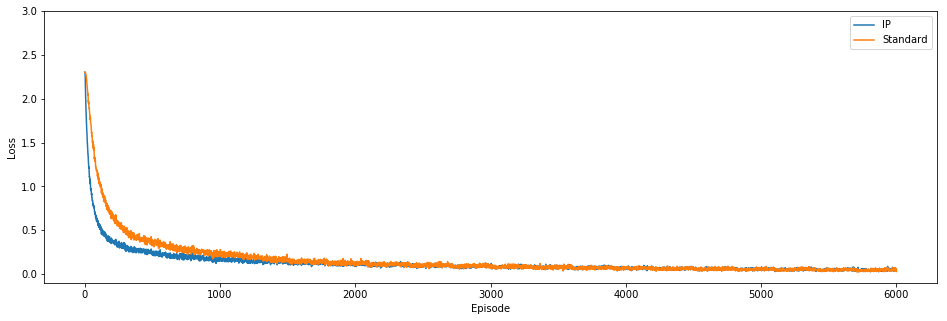

In [7]:
syn_lr = 0.001

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 0.609
[2] loss: 0.279
[3] loss: 0.210
[4] loss: 0.169
[5] loss: 0.139
[6] loss: 0.122
[7] loss: 0.108
[8] loss: 0.098
[9] loss: 0.085
[10] loss: 0.080
[11] loss: 0.074
[12] loss: 0.070
[13] loss: 0.064
[14] loss: 0.058
[15] loss: 0.055
[16] loss: 0.052
[17] loss: 0.049
[18] loss: 0.046
[19] loss: 0.042
[20] loss: 0.039
Finished training!

Training Standard Net. Run 1
[1] loss: 0.977
[2] loss: 0.308
[3] loss: 0.210
[4] loss: 0.174
[5] loss: 0.146
[6] loss: 0.127
[7] loss: 0.114
[8] loss: 0.105
[9] loss: 0.095
[10] loss: 0.092
[11] loss: 0.086
[12] loss: 0.079
[13] loss: 0.077
[14] loss: 0.070
[15] loss: 0.067
[16] loss: 0.073
[17] loss: 0.062
[18] loss: 0.064
[19] loss: 0.060
[20] loss: 0.061
Finished training!

Training IP Net. Run 2
[1] loss: 0.516
[2] loss: 0.248
[3] loss: 0.188
[4] loss: 0.157
[5] loss: 0.135
[6] loss: 0.120
[7] loss: 0.109
[8] loss: 0.099
[9] loss: 0.093
[10] loss: 0.083
[11] loss: 0.078
[12] loss: 0.072
[13] loss: 0.067
[14] loss: 

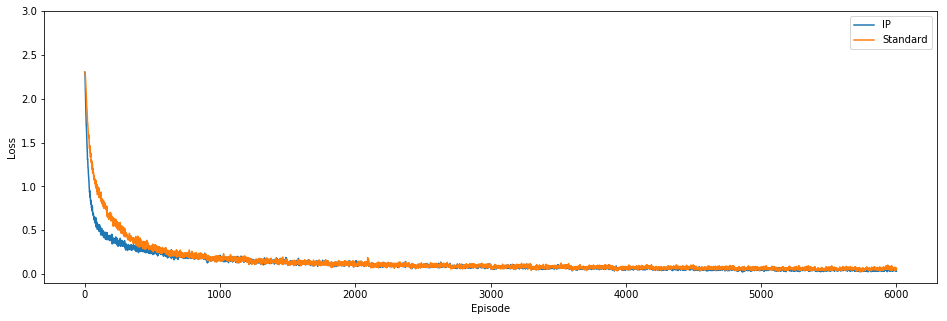

In [8]:
syn_lr = 0.003

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 0.604
[2] loss: 0.254
[3] loss: 0.178
[4] loss: 0.146
[5] loss: 0.123
[6] loss: 0.109
[7] loss: 0.096
[8] loss: 0.086
[9] loss: 0.084
[10] loss: 0.073
[11] loss: 0.066
[12] loss: 0.060
[13] loss: 0.062
[14] loss: 0.055
[15] loss: 0.053
[16] loss: 0.048
[17] loss: 0.047
[18] loss: 0.047
[19] loss: 0.041
[20] loss: 0.041
Finished training!

Training Standard Net. Run 1
[1] loss: 0.648
[2] loss: 0.389
[3] loss: 0.360
[4] loss: 0.302
[5] loss: 0.307
[6] loss: 0.292
[7] loss: 0.292
[8] loss: 0.300
[9] loss: 0.304
[10] loss: 0.306
[11] loss: 0.318
[12] loss: 0.340
[13] loss: 0.357
[14] loss: 0.377
[15] loss: 0.352
[16] loss: 0.378
[17] loss: 0.374
[18] loss: 0.360
[19] loss: 0.382
[20] loss: 0.350
Finished training!

Training IP Net. Run 2
[1] loss: 0.764
[2] loss: 0.281
[3] loss: 0.193
[4] loss: 0.157
[5] loss: 0.133
[6] loss: 0.112
[7] loss: 0.101
[8] loss: 0.090
[9] loss: 0.083
[10] loss: 0.075
[11] loss: 0.072
[12] loss: 0.065
[13] loss: 0.057
[14] loss: 

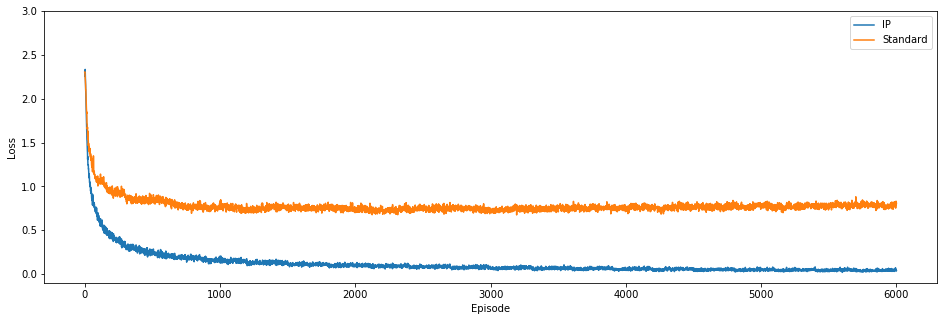

In [9]:
syn_lr = 0.01

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 0.754
[2] loss: 0.295
[3] loss: 0.201
[4] loss: 0.159
[5] loss: 0.136
[6] loss: 0.120
[7] loss: 0.106
[8] loss: 0.101
[9] loss: 0.089
[10] loss: 0.082
[11] loss: 0.076
[12] loss: 0.073
[13] loss: 0.069
[14] loss: 0.063
[15] loss: 0.058
[16] loss: 0.058
[17] loss: 0.058
[18] loss: 0.053
[19] loss: 0.053
[20] loss: 0.045
Finished training!

Training Standard Net. Run 1
[1] loss: 2.284
[2] loss: 2.310
[3] loss: 2.310
[4] loss: 2.310
[5] loss: 2.310
[6] loss: 2.310
[7] loss: 2.310
[8] loss: 2.310
[9] loss: 2.310
[10] loss: 2.310
[11] loss: 2.310
[12] loss: 2.310
[13] loss: 2.310
[14] loss: 2.310
[15] loss: 2.310
[16] loss: 2.310
[17] loss: 2.310
[18] loss: 2.310
[19] loss: 2.310
[20] loss: 2.310
Finished training!

Training IP Net. Run 2
[1] loss: 0.697
[2] loss: 0.276
[3] loss: 0.194
[4] loss: 0.153
[5] loss: 0.129
[6] loss: 0.114
[7] loss: 0.100
[8] loss: 0.091
[9] loss: 0.087
[10] loss: 0.075
[11] loss: 0.070
[12] loss: 0.068
[13] loss: 0.065
[14] loss: 

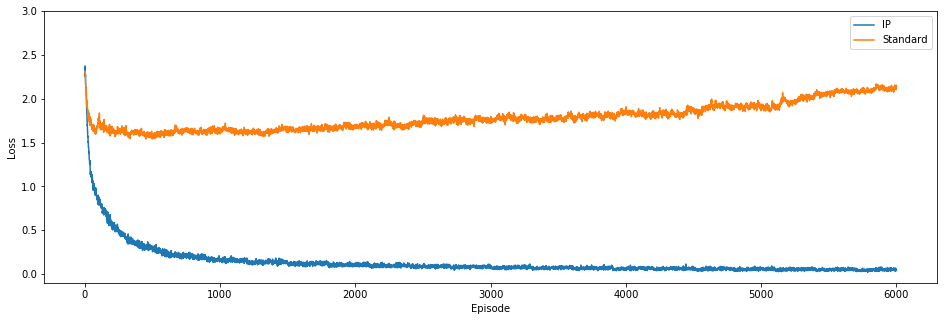

In [10]:
syn_lr = 0.016

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

# CIFAR-10 Tests

In [11]:
batchSize = 200

transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 150
epochs = 40

test_runs = 10

int_lr = 0.1

Training IP Net. Run 1
[1] loss: 2.033
[2] loss: 1.908
[3] loss: 1.851
[4] loss: 1.821
[5] loss: 1.774
[6] loss: 1.757
[7] loss: 1.748
[8] loss: 1.707
[9] loss: 1.695
[10] loss: 1.667
[11] loss: 1.652
[12] loss: 1.642
[13] loss: 1.615
[14] loss: 1.593
[15] loss: 1.578
[16] loss: 1.552
[17] loss: 1.543
[18] loss: 1.535
[19] loss: 1.521
[20] loss: 1.520
[21] loss: 1.501
[22] loss: 1.494
[23] loss: 1.481
[24] loss: 1.474
[25] loss: 1.462
[26] loss: 1.454
[27] loss: 1.440
[28] loss: 1.427
[29] loss: 1.419
[30] loss: 1.404
[31] loss: 1.394
[32] loss: 1.389
[33] loss: 1.377
[34] loss: 1.367
[35] loss: 1.355
[36] loss: 1.347
[37] loss: 1.337
[38] loss: 1.325
[39] loss: 1.312
[40] loss: 1.305
Finished training!

Training Standard Net. Run 1
[1] loss: 2.146
[2] loss: 1.890
[3] loss: 1.795
[4] loss: 1.728
[5] loss: 1.691
[6] loss: 1.650
[7] loss: 1.614
[8] loss: 1.580
[9] loss: 1.549
[10] loss: 1.520
[11] loss: 1.489
[12] loss: 1.471
[13] loss: 1.441
[14] loss: 1.430
[15] loss: 1.402
[16] loss: 

[18] loss: 1.334
[19] loss: 1.313
[20] loss: 1.306
[21] loss: 1.294
[22] loss: 1.276
[23] loss: 1.269
[24] loss: 1.246
[25] loss: 1.230
[26] loss: 1.232
[27] loss: 1.214
[28] loss: 1.204
[29] loss: 1.186
[30] loss: 1.177
[31] loss: 1.168
[32] loss: 1.155
[33] loss: 1.143
[34] loss: 1.132
[35] loss: 1.128
[36] loss: 1.115
[37] loss: 1.106
[38] loss: 1.090
[39] loss: 1.087
[40] loss: 1.081
Finished training!

Training IP Net. Run 7
[1] loss: 2.014
[2] loss: 1.907
[3] loss: 1.858
[4] loss: 1.810
[5] loss: 1.774
[6] loss: 1.757
[7] loss: 1.731
[8] loss: 1.708
[9] loss: 1.701
[10] loss: 1.670
[11] loss: 1.648
[12] loss: 1.625
[13] loss: 1.608
[14] loss: 1.585
[15] loss: 1.582
[16] loss: 1.563
[17] loss: 1.549
[18] loss: 1.540
[19] loss: 1.524
[20] loss: 1.509
[21] loss: 1.506
[22] loss: 1.488
[23] loss: 1.473
[24] loss: 1.466
[25] loss: 1.455
[26] loss: 1.445
[27] loss: 1.435
[28] loss: 1.419
[29] loss: 1.414
[30] loss: 1.417
[31] loss: 1.397
[32] loss: 1.388
[33] loss: 1.385
[34] loss: 1.3

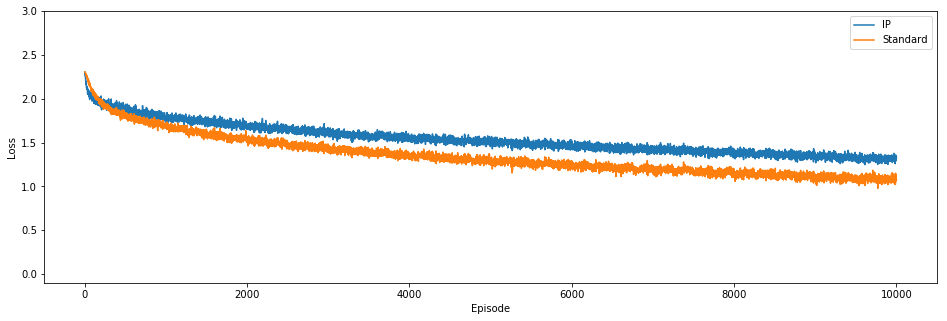

In [13]:
syn_lr = 0.0003

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 2.028
[2] loss: 1.897
[3] loss: 1.837
[4] loss: 1.808
[5] loss: 1.761
[6] loss: 1.727
[7] loss: 1.693
[8] loss: 1.674
[9] loss: 1.648
[10] loss: 1.629
[11] loss: 1.611
[12] loss: 1.589
[13] loss: 1.571
[14] loss: 1.558
[15] loss: 1.545
[16] loss: 1.531
[17] loss: 1.518
[18] loss: 1.501
[19] loss: 1.488
[20] loss: 1.475
[21] loss: 1.463
[22] loss: 1.442
[23] loss: 1.428
[24] loss: 1.418
[25] loss: 1.404
[26] loss: 1.395
[27] loss: 1.380
[28] loss: 1.369
[29] loss: 1.361
[30] loss: 1.349
[31] loss: 1.331
[32] loss: 1.324
[33] loss: 1.308
[34] loss: 1.298
[35] loss: 1.291
[36] loss: 1.277
[37] loss: 1.265
[38] loss: 1.254
[39] loss: 1.238
[40] loss: 1.229
Finished training!

Training Standard Net. Run 1
[1] loss: 2.004
[2] loss: 1.847
[3] loss: 1.785
[4] loss: 1.728
[5] loss: 1.679
[6] loss: 1.638
[7] loss: 1.606
[8] loss: 1.568
[9] loss: 1.531
[10] loss: 1.517
[11] loss: 1.487
[12] loss: 1.477
[13] loss: 1.452
[14] loss: 1.431
[15] loss: 1.415
[16] loss: 

[18] loss: 2.312
[19] loss: 2.312
[20] loss: 2.312
[21] loss: 2.312
[22] loss: 2.312
[23] loss: 2.312
[24] loss: 2.312
[25] loss: 2.312
[26] loss: 2.312
[27] loss: 2.312
[28] loss: 2.312
[29] loss: 2.312
[30] loss: 2.312
[31] loss: 2.312
[32] loss: 2.312
[33] loss: 2.312
[34] loss: 2.312
[35] loss: 2.312
[36] loss: 2.312
[37] loss: 2.312
[38] loss: 2.312
[39] loss: 2.312
[40] loss: 2.312
Finished training!

Training IP Net. Run 7
[1] loss: 2.045
[2] loss: 1.895
[3] loss: 1.847
[4] loss: 1.803
[5] loss: 1.776
[6] loss: 1.756
[7] loss: 1.727
[8] loss: 1.689
[9] loss: 1.663
[10] loss: 1.647
[11] loss: 1.622
[12] loss: 1.608
[13] loss: 1.588
[14] loss: 1.574
[15] loss: 1.556
[16] loss: 1.543
[17] loss: 1.527
[18] loss: 1.512
[19] loss: 1.497
[20] loss: 1.487
[21] loss: 1.473
[22] loss: 1.460
[23] loss: 1.452
[24] loss: 1.435
[25] loss: 1.421
[26] loss: 1.412
[27] loss: 1.398
[28] loss: 1.385
[29] loss: 1.372
[30] loss: 1.362
[31] loss: 1.352
[32] loss: 1.340
[33] loss: 1.326
[34] loss: 1.3

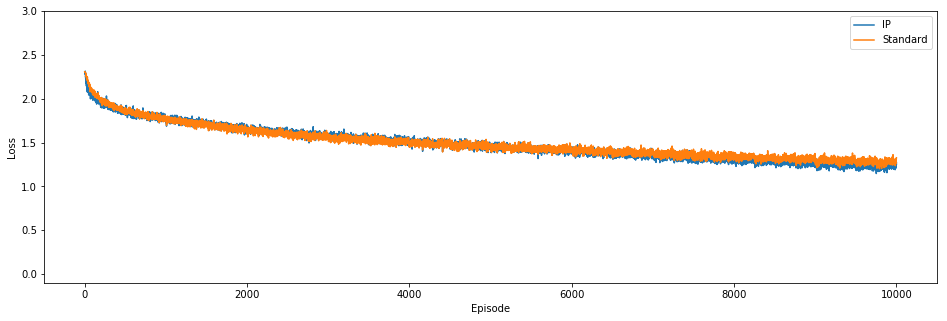

In [14]:
syn_lr = 0.0006

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 2.039
[2] loss: 1.882
[3] loss: 1.815
[4] loss: 1.767
[5] loss: 1.732
[6] loss: 1.688
[7] loss: 1.660
[8] loss: 1.634
[9] loss: 1.613
[10] loss: 1.591
[11] loss: 1.576
[12] loss: 1.558
[13] loss: 1.537
[14] loss: 1.518
[15] loss: 1.502
[16] loss: 1.488
[17] loss: 1.465
[18] loss: 1.452
[19] loss: 1.438
[20] loss: 1.421
[21] loss: 1.407
[22] loss: 1.394
[23] loss: 1.375
[24] loss: 1.365
[25] loss: 1.349
[26] loss: 1.342
[27] loss: 1.328
[28] loss: 1.315
[29] loss: 1.300
[30] loss: 1.286
[31] loss: 1.277
[32] loss: 1.267
[33] loss: 1.250
[34] loss: 1.240
[35] loss: 1.224
[36] loss: 1.215
[37] loss: 1.202
[38] loss: 1.191
[39] loss: 1.182
[40] loss: 1.169
Finished training!

Training Standard Net. Run 1
[1] loss: 2.079
[2] loss: 1.912
[3] loss: 1.838
[4] loss: 1.816
[5] loss: 1.774
[6] loss: 1.753
[7] loss: 1.726
[8] loss: 1.717
[9] loss: 1.691
[10] loss: 1.675
[11] loss: 1.669
[12] loss: 1.639
[13] loss: 1.620
[14] loss: 1.619
[15] loss: 1.594
[16] loss: 

[18] loss: 1.549
[19] loss: 1.533
[20] loss: 1.521
[21] loss: 1.519
[22] loss: 1.512
[23] loss: 1.508
[24] loss: 1.487
[25] loss: 1.480
[26] loss: 1.472
[27] loss: 1.463
[28] loss: 1.466
[29] loss: 1.463
[30] loss: 1.439
[31] loss: 1.445
[32] loss: 1.440
[33] loss: 1.419
[34] loss: 1.417
[35] loss: 1.407
[36] loss: 1.406
[37] loss: 1.409
[38] loss: 1.389
[39] loss: 1.383
[40] loss: 1.381
Finished training!

Training IP Net. Run 7
[1] loss: 2.064
[2] loss: 1.930
[3] loss: 1.872
[4] loss: 1.834
[5] loss: 1.784
[6] loss: 1.749
[7] loss: 1.710
[8] loss: 1.679
[9] loss: 1.651
[10] loss: 1.626
[11] loss: 1.605
[12] loss: 1.586
[13] loss: 1.562
[14] loss: 1.547
[15] loss: 1.529
[16] loss: 1.514
[17] loss: 1.490
[18] loss: 1.477
[19] loss: 1.457
[20] loss: 1.437
[21] loss: 1.425
[22] loss: 1.406
[23] loss: 1.389
[24] loss: 1.374
[25] loss: 1.356
[26] loss: 1.339
[27] loss: 1.325
[28] loss: 1.315
[29] loss: 1.300
[30] loss: 1.287
[31] loss: 1.272
[32] loss: 1.265
[33] loss: 1.250
[34] loss: 1.2

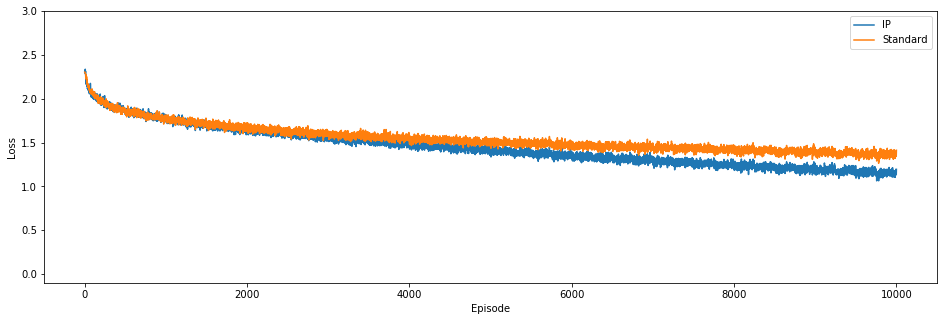

In [15]:
syn_lr = 0.001
run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 2.122
[2] loss: 1.985
[3] loss: 1.895
[4] loss: 1.837
[5] loss: 1.796
[6] loss: 1.765
[7] loss: 1.715
[8] loss: 1.679
[9] loss: 1.647
[10] loss: 1.615
[11] loss: 1.583
[12] loss: 1.556
[13] loss: 1.532
[14] loss: 1.510
[15] loss: 1.482
[16] loss: 1.459
[17] loss: 1.439
[18] loss: 1.424
[19] loss: 1.406
[20] loss: 1.392
[21] loss: 1.376
[22] loss: 1.358
[23] loss: 1.345
[24] loss: 1.328
[25] loss: 1.313
[26] loss: 1.295
[27] loss: 1.281
[28] loss: 1.271
[29] loss: 1.256
[30] loss: 1.238
[31] loss: 1.230
[32] loss: 1.215
[33] loss: 1.206
[34] loss: 1.189
[35] loss: 1.179
[36] loss: 1.172
[37] loss: 1.159
[38] loss: 1.150
[39] loss: 1.137
[40] loss: 1.120
Finished training!

Training Standard Net. Run 1
[1] loss: 2.128
[2] loss: 2.018
[3] loss: 1.994
[4] loss: 1.979
[5] loss: 1.951
[6] loss: 1.933
[7] loss: 1.930
[8] loss: 1.922
[9] loss: 1.952
[10] loss: 1.949
[11] loss: 1.953
[12] loss: 1.930
[13] loss: 1.918
[14] loss: 1.920
[15] loss: 1.927
[16] loss: 

[18] loss: 2.312
[19] loss: 2.312
[20] loss: 2.312
[21] loss: 2.312
[22] loss: 2.312
[23] loss: 2.312
[24] loss: 2.312
[25] loss: 2.312
[26] loss: 2.312
[27] loss: 2.312
[28] loss: 2.312
[29] loss: 2.312
[30] loss: 2.312
[31] loss: 2.312
[32] loss: 2.312
[33] loss: 2.312
[34] loss: 2.312
[35] loss: 2.312
[36] loss: 2.312
[37] loss: 2.312
[38] loss: 2.312
[39] loss: 2.312
[40] loss: 2.312
Finished training!

Training IP Net. Run 7
[1] loss: 2.072
[2] loss: 1.899
[3] loss: 1.837
[4] loss: 1.790
[5] loss: 1.749
[6] loss: 1.714
[7] loss: 1.686
[8] loss: 1.653
[9] loss: 1.619
[10] loss: 1.582
[11] loss: 1.553
[12] loss: 1.527
[13] loss: 1.502
[14] loss: 1.479
[15] loss: 1.461
[16] loss: 1.441
[17] loss: 1.426
[18] loss: 1.406
[19] loss: 1.392
[20] loss: 1.376
[21] loss: 1.362
[22] loss: 1.347
[23] loss: 1.332
[24] loss: 1.316
[25] loss: 1.300
[26] loss: 1.287
[27] loss: 1.270
[28] loss: 1.253
[29] loss: 1.240
[30] loss: 1.227
[31] loss: 1.220
[32] loss: 1.196
[33] loss: 1.186
[34] loss: 1.1

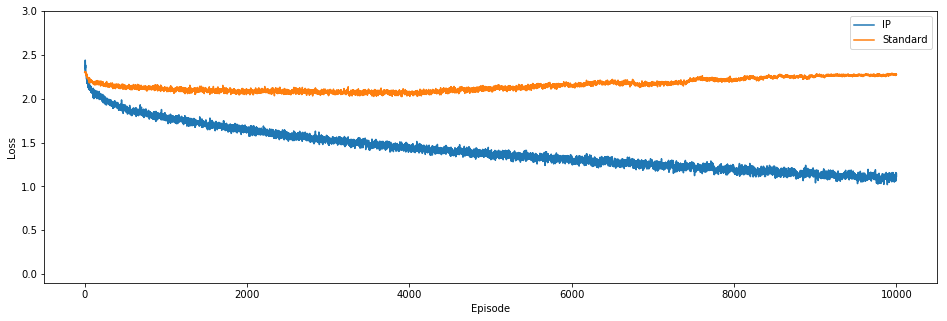

In [16]:
syn_lr = 0.002

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)